<a href="https://colab.research.google.com/github/tshrove/phd-project/blob/master/IEEE_Software_C_SimpleRegressionFinite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import numpy as np
from IPython.display import display

jira_project_name = 'CDRIVER'
github_project_name = 'mongodb/mongo-c-driver'
sampling_freq = 'M'
weeks_of_prediction = 4
weeks_of_training = 10

## Getting the Defect Data
Need to get the defect data from excel spreadsheet.

In [0]:
from google.colab import files

uploaded = files.upload()
  
# Import TD data
defects_dataframe = pd.read_csv('SELECT_t___FROM_db_dbprojecttdevent4_t.csv', index_col = 0, parse_dates=True)
# Convert event_date column to datetime column for analysis
defects_dataframe['event_date'] = pd.to_datetime(defects_dataframe['event_date'])
defects_dataframe = defects_dataframe.set_index('event_date')

Saving SELECT_t___FROM_db_dbprojecttdevent4_t.csv to SELECT_t___FROM_db_dbprojecttdevent4_t (2).csv


## Getting the Stargazer Data.
Need to get the stargazer data from the excel spreadsheet.

In [0]:
uploaded = files.upload()

# Import DBStar Data
stargazer_dataframe = pd.read_csv('SELECT_t___FROM_db_dbstar_t.csv', index_col = 0, parse_dates=True)
# Convert event_date column to datetime column for analysis
stargazer_dataframe['event_date'] = pd.to_datetime(stargazer_dataframe['event_date'])
stargazer_dataframe = stargazer_dataframe.set_index('event_date')

Saving SELECT_t___FROM_db_dbstar_t.csv to SELECT_t___FROM_db_dbstar_t (2).csv


##  Getting and Filtering the Data
Here we are filter the data to the exact projects we need it from and plotting it out.

In [0]:
def get_filter_data(jira_proj, github_proj):
  # filter td data to one project
  df1 = defects_dataframe[defects_dataframe.projectkey == jira_proj]
  # filter stargazer data to one project
  df2 = stargazer_dataframe[stargazer_dataframe.repokey == github_proj]
  return df1, df2

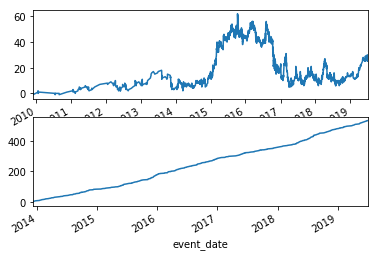

In [0]:
node_dataframe, node_sg_dataframe = get_filter_data(jira_project_name, github_project_name)

fig = plt.figure()
ax1 = plt.subplot(211)
node_dataframe['cumlative_value'].plot()

ax2 = plt.subplot(212)
node_sg_dataframe['cumlative_value'].plot()

## Create a column normalization function to use.

In [0]:
def normalize_column(df, column_name):
  # Create x, where x the 'scores' column's values as floats
  x = df[[column_name]].values.astype(float)

  # Create a minimum and maximum processor object
  min_max_scaler = preprocessing.MinMaxScaler()

  # Create an object to transform the data to fit minmax processor
  x_scaled = min_max_scaler.fit_transform(x)

  # Run the normalizer on the dataframe
  return x_scaled

Use the normalization function on both datasets and plot the results.

In [0]:
def normalize_cumlative_value_col(column_name):
  node_dataframe['cumlative_value_percentage'] = normalize_column(node_dataframe, column_name)
  node_sg_dataframe['cumlative_value_percentage']= normalize_column(node_sg_dataframe, column_name)
  # Get the data to a series of the cumlative_value column
  plt.subplot(211)
  node_dataframe['cumlative_value_percentage'].plot()
  plt.subplot(212)
  node_sg_dataframe['cumlative_value_percentage'].plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


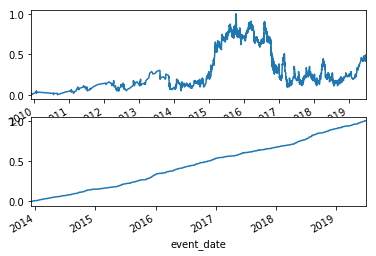

In [0]:
normalize_cumlative_value_col('cumlative_value')

## Finding the earliest and most recent dates
We are trying to find the earliest and most recent datas on the project in order to now how long the actual project lasted.

In [0]:
def find_oldest_and_most_recent_dates(df1, df2, col_name):
  #remove the indexing
  df1.reset_index(inplace=True)
  df2.reset_index(inplace=True)

  # find the normalization min value for x axis
  earliest_sg_date = df2[col_name].min()
  earliest_td_date = df1[col_name].min()
  earliest_date = min(earliest_sg_date, earliest_td_date)

  #find the normalization max value for x axis
  most_recent_sg_date = df2[col_name].max()
  most_recent_td_date = df1[col_name].max()
  most_recent_date = min(most_recent_sg_date, most_recent_td_date)
  
  return earliest_date, most_recent_date

In [0]:
earliest_date, most_recent_date = find_oldest_and_most_recent_dates(node_dataframe, node_sg_dataframe, 'event_date')
print(earliest_date)
print(most_recent_date)

2009-12-31 00:00:00
2019-07-31 00:00:00


## Resample the DataFrame
Need to resample the series for the specified sampling frequency and reset the index.

In [0]:
def resample_dataframe(df):
  df.groupby('event_date').cumlative_value_percentage.last()
  df.drop_duplicates(subset='event_date', keep='last', inplace=True)
  df = df.set_index('event_date')
  df = df.resample(sampling_freq).mean().bfill()
  return df

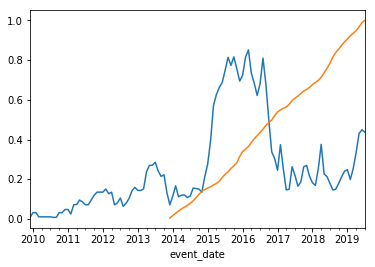

In [0]:
node_dataframe = resample_dataframe(node_dataframe)
node_dataframe['cumlative_value_percentage'].plot()

node_sg_dataframe = resample_dataframe(node_sg_dataframe)
node_sg_dataframe['cumlative_value_percentage'].plot()

In [0]:
#
# merging the two data points together in order to normalize on the x axis
#
def merge_two_dataframes(df1, df2, early_date, latest_date, samp_freq):
  merged_df = pd.DataFrame(columns=['date', 'td', 'sg'])
  merged_df['date'] = pd.date_range(early_date, latest_date, freq=samp_freq, normalize=True)
  merged_df = merged_df.set_index('date')
  merged_df['sg'] = df2['cumlative_value_percentage']
  merged_df['td'] = df1['cumlative_value_percentage']
  merged_df['td'][0] = 0
  merged_df['td'] = merged_df['td'].fillna(method='ffill')
  return merged_df

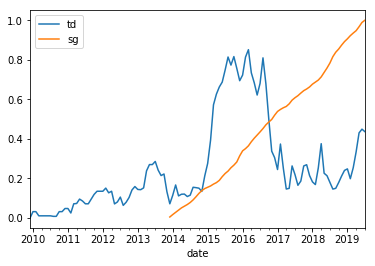

In [0]:
merged_df = merge_two_dataframes(node_dataframe, node_sg_dataframe, earliest_date, most_recent_date, sampling_freq)
merged_df.plot()

In [0]:
#
# Perform the normalization
#
def create_and_normalize_new_index(df):
  scalar = MinMaxScaler(feature_range=(0, 1))
  scaled_merged_df = scalar.fit_transform(df)
  scaled_merged_df = pd.DataFrame(scaled_merged_df, columns=['td', 'sg'])
  scaled_merged_df['normalized_index'] = scaled_merged_df.index.tolist() / scaled_merged_df.index.to_series().count()
  scaled_merged_df = scaled_merged_df.set_index('normalized_index')
  return scaled_merged_df

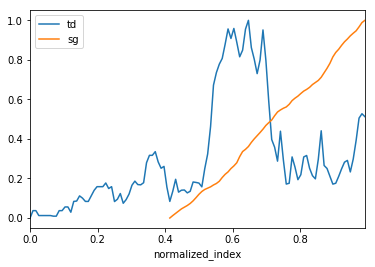

In [0]:
scaled_merged_df = create_and_normalize_new_index(merged_df)
scaled_merged_df.plot()

In [0]:
def create_sp2d2_series(df):
  df['td_pct_diff'] = df['td'].pct_change().fillna(0)
  df['sg_pct_diff'] = df['sg'].pct_change().fillna(0)
  df['sp2d2'] = df['sg'] - df['td']
  df['sp2d2'] = df['sp2d2'].replace([np.inf, -np.inf], np.nan)
  return df

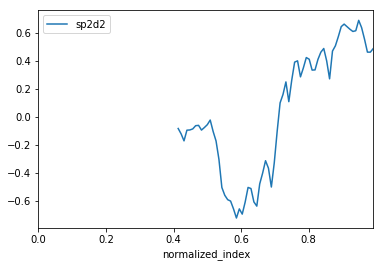

In [0]:
scaled_merged_df = create_sp2d2_series(scaled_merged_df)
scaled_merged_df.plot(y='sp2d2')

## Split the Data for Training and Testing
Here I am splitting the data into training and test data. I could've used the split_train_test function however, it would not return something or perform the correct action I needed so i created my own. I also needed two training datasets.

In [0]:
def split_data_train_test(df):
  # put the data into np arrays
  x = np.array(df.index.tolist()).reshape(-1, 1)
  y = np.array(df['sp2d2']).reshape(-1, 1)

  # split the data into training and test data.
  n = len(x)
  x_train = x[:int(n - weeks_of_prediction)]
  x_test = x[int(n - weeks_of_prediction):]

  # further splitting (split training data into 10% of original training size)
  n=len(x_train)
  x_train2 = x_train[int(n - weeks_of_training):]

  m = len(y)
  y_train = y[:int(m - weeks_of_prediction)]
  y_test = y[int(m - weeks_of_prediction):]

  # further splitting (split training data into 10% of original training size)
  m=len(y_train)
  y_train2 = y_train[int(m - weeks_of_training):]
  return x_train, x_test, y_train, y_test, x_train2, y_train2

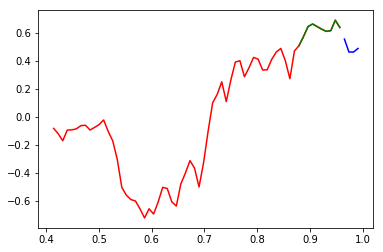

In [0]:
x_train, x_test, y_train, y_test, x_train2, y_train2 = split_data_train_test(scaled_merged_df)

# plot the data
plt.plot(x_train, y_train, c='r', label='training data')
plt.plot(x_test, y_test, c='b', label='testing data')
plt.plot(x_train2, y_train2, c='g', label='testing data')

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_reg = PolynomialFeatures(degree=1, interaction_only=False, include_bias=False)
x_poly = poly_reg.fit_transform(x_train2)
pol_reg = LinearRegression()
pol_reg.fit(x_poly, y_train2)
y_predict = pol_reg.predict(poly_reg.fit_transform(x_test))

In [0]:
from sklearn.metrics import mean_squared_error

# Get the mean squared error
mse = mean_squared_error(y_test, y_predict)
print(mse)

0.041854078052738324


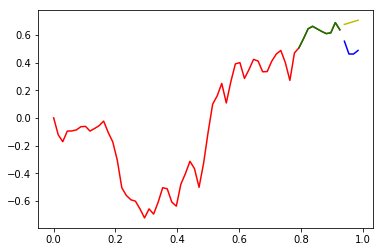

In [0]:
# plot the data
plt.plot(x_train, y_train, c='r', label='training data')
plt.plot(x_test, y_test, c='b', label='testing data')
plt.plot(x_train2, y_train2, c='g', label='testing data')
plt.plot(x_test, y_predict, c='y', label='regression')